# Predicting the effect of gene knockouts on unseen cytokine-induced cell lines

In this tutorial, we predict the effect of genetic knockouts on unseen combinations of pathway and cell lines. Therefore, we consider [a dataset](https://www.nature.com/articles/s41556-025-01622-z2) which captures the effect of genetic knockouts on 6 cancer cell lines stimulated with 5 different cytokines.

## Preliminaries

The dataset is relatively large, hence we use [rapids-single-cell](https://rapids-singlecell.readthedocs.io/en/latest/index.html) which allows us to leverage GPU acceleration for preprocessing and downstream tasks. This notebook is executed on a A100 GPU with 80GB memory, as well as 500GB CPU memory. 

We also require `mygene` to translate gene names to Ensembl IDs, it can be installed via `pip install mygene`

In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
from tqdm import tqdm
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca, get_esm_embedding
from cellflow.metrics import compute_r_squared, compute_e_distance


/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/satija_tmp/adata_satija_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 1628476 × 33056
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'cell_type', 'percent.mito', 'sample_ID', 'Batch_info', 'bc1_well', 'bc2_well', 'bc3_well', 'guide', 'gene', 'mixscale_score', 'pathway'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_line_embedding', 'cell_type_colors', 'gene_embeddings', 'hvg', 'log1p', 'neighbors', 'pathway_colors', 'pathway_embeddings', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,sample,cell_type,percent.mito,sample_ID,Batch_info,bc1_well,bc2_well,bc3_well,guide,gene,mixscale_score,pathway
05_54_42_1_1_1_1_1_1_1_1_1,05,15381.0,5362,A549_IFNG,A549,5.961901,sample_1,Rep1,NaN,NaN,NaN,ATF3g2,ATF3,1.176385,IFNG
08_58_81_1_1_1_1_1_1_1_1_1,08,13534.0,4995,A549_IFNG,A549,1.780700,sample_1,Rep1,NaN,NaN,NaN,STAT2g1,STAT2,-0.787551,IFNG
06_01_92_1_1_1_1_1_1_1_1_1,06,11520.0,4454,A549_IFNG,A549,9.644097,sample_1,Rep1,NaN,NaN,NaN,CUL1g1,CUL1,4.208174,IFNG
05_33_45_1_1_1_1_1_1_1_1_1,05,11174.0,4575,A549_IFNG,A549,4.966887,sample_1,Rep1,NaN,NaN,NaN,IRF2g2,IRF2,-0.345167,IFNG
06_35_73_1_1_1_1_1_1_1_1_1,06,10807.0,3961,A549_IFNG,A549,13.528269,sample_1,Rep1,NaN,NaN,NaN,MYCg2,MYC,-0.182128,IFNG


Let's have a look at the most relevant columns:
- {attr}`obs['cell_type'] <anndata.AnnData.obs>` contains one out of six cancer cell lines. 
- {attr}`obs['pathway'] <anndata.AnnData.obs>` contains the cytokine treatment of the cell line. There are five different ones in total.
- {attr}`obs['gene'] <anndata.AnnData.obs>` tells us which gene has been knocked out.

We create columns which will come in handy later:

In [4]:
adata.obs["condition"] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.pathway, x.gene]), axis=1)
adata.obs["tissue_context"] = adata.obs.apply(lambda x: "_".join([x.cell_type, x.pathway]), axis=1)
adata.obs["is_control"] = adata.obs.apply(lambda x: x["gene"] == "NT", axis=1)

While embeddings of the cell lines are provided in  {attr}`obs['cell_line_embedding'] <anndata.AnnData.uns>`, we still need a representation for the genetic knockouts. Therefore, we leverage CellFlow's {func}`~cellflow.preprocessing.get_esm_embedding`. However, {func}`~cellflow.preprocessing.get_esm_embedding` requires [ensembl IDs](https://www.ensembl.org/index.html). Hence, we first need to convert the genes:

In [24]:
from mygene import MyGeneInfo

mg = MyGeneInfo()
genes = adata.obs["gene"].unique()
out = mg.querymany(genes, scopes='symbol', fields='ensembl.gene', species='human')


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
3 input query terms found no hit:	['NT', 'RARRES3', 'H1F0']


Not all genes could be mapped. In particular, 'NT' is the control state, hence, we don't need a representation for it. 'RARRES3' refers to the same gene as 'PLAAT4', and similarly 'H1F0' to 'H1-0'.

In [25]:
additional_genes = ["PLAAT4", "H1-0"]
out_2 = mg.querymany(additional_genes, scopes='symbol', fields='ensembl.gene', species='human')
out.extend(out_2)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [44]:
genes_to_ignore = ['NT', 'RARRES3', 'H1F0']
gene_to_ensembl = {}
genes_to_verify = []
for gene in out:
    if gene["query"] in genes_to_ignore:
        continue
    elif len(gene["ensembl"]) > 1:
        genes_to_verify.append(gene)
    else:
        gene_to_ensembl[gene["query"]] = gene["ensembl"]["gene"]        

Whenever there is not a unique match, we have to fill the dictionary `gene_to_ensembl` manually"

In [53]:
gene_to_ensembl["ZC3H3"] = "ENSG00000014164"
gene_to_ensembl["IFNGR2"] = "ENSG00000159128"
gene_to_ensembl["SRC"] = "ENSG00000197122"
gene_to_ensembl["IRF7"] = "ENSG00000185507"
gene_to_ensembl["HLA-DQB1"] = "ENSG00000179344"
gene_to_ensembl["IRF9"] = "ENSG00000213928"
gene_to_ensembl["ID3"] = "ENSG00000117318"
gene_to_ensembl["MAP3K14"] = "ENSG00000282637"
gene_to_ensembl["ITCH"] = "ENSG00000078747"
gene_to_ensembl["HRAS"] = "ENSG00000174775"
gene_to_ensembl["PTEN"] = "ENSG00000171862"
gene_to_ensembl["HSF1"] = "ENSG00000185122"

gene_to_ensembl["NT"] = "control"

adata.obs["gene_ensembl"] = adata.obs["gene"].map(gene_to_ensembl)

In [56]:
adata.obs["gene_ensembl"].value_counts(dropna=False)

gene_ensembl
control            84269
ENSG00000125347    30300
ENSG00000136997    24952
ENSG00000126767    23425
ENSG00000177606    23145
                   ...  
ENSG00000132170      844
ENSG00000113558      787
ENSG00000187778      713
ENSG00000073584      689
ENSG00000181449      329
Name: count, Length: 218, dtype: int64

Finally, we can retrieve the ESM embeddings and save it to `gene_emb_key="esm_embeddings"`. We can use different ESM models, here we use ESM2 (`esm_model_name = "esm2_t36_3B_UR50D"`):

In [55]:
get_esm_embedding(adata, gene_key="gene_ensembl", gene_emb_key="esm_embeddings", null_value = "control", esm_model_name="esm2_t36_3B_UR50D")

WARNING  HF_HOME environment variable is not set and `cache_dir` is None.                 Cache will be stored in  
         the current directory.                                                                                    


HTTPError: 400 Client Error: Bad Request for url: https://rest.ensembl.org/lookup/id/nan?expand=1

We now perform standard 

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.X = adata.X.astype("float32")

We then perform highly variable gene selection. As the set of highly variable genes depends a lot on {attr}`obs['tissue_context']`, we take the union of HVGs per {attr}`obs['tissue_context']`. 

In [6]:
n_top_genes_per_condition = 500 
highly_var_genes = {}
for t_context in tqdm(adata.obs['tissue_context'].unique()):
    temp = adata[adata.obs['tissue_context'] == t_context, :]
    sc.pp.highly_variable_genes(temp, inplace=True, n_top_genes=n_top_genes_per_condition)
    temp = adata[:, temp.var["highly_variable"]==True]
    highly_var_genes[t_context] = set(temp.var.index)
    del temp 


100%|██████████| 30/30 [02:05<00:00,  4.17s/it]


In [7]:
hvgs = {gene for v in highly_var_genes.values() for gene in v}
adata = adata[:, adata.var.index.isin(hvgs)]

We visualize the data:

[2025-04-14 15:14:42.158] [CUML] [debug] n_neighbors=15
[2025-04-14 15:14:42.181] [CUML] [debug] Calling knn graph run
[2025-04-14 15:14:42.181] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-04-14 15:14:43.174] [CUML] [debug] Done. Calling remove zeros


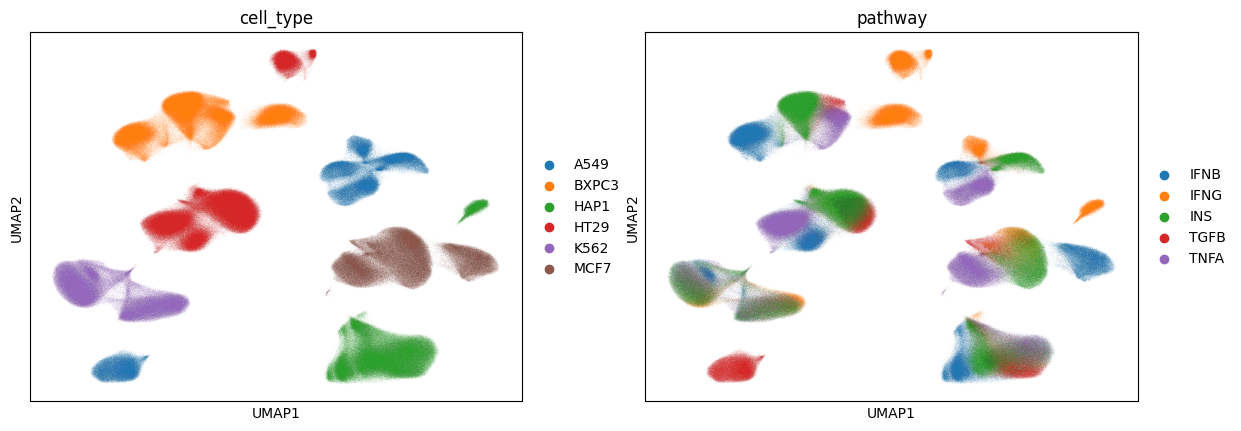

In [8]:
rsc.pp.pca(adata)
rsc.pp.neighbors(adata, use_rep="X_pca")
rsc.tl.umap(adata)
sc.pl.umap(adata, color=["cell_type", "pathway"])

We also visualize the control cells, which gives a visual impression that perturbation effects are not too strong:

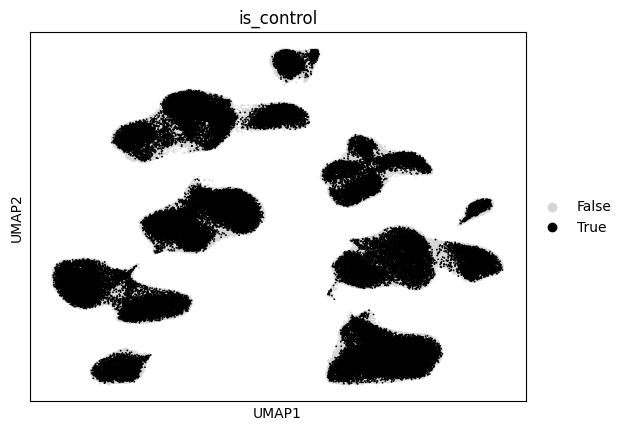

In [9]:
order = list(adata[~adata.obs["is_control"].to_numpy()].obs_names) + list(adata[adata.obs["is_control"].to_numpy()].obs_names)
adata.obs["is_control_str"] = adata.obs["is_control"].astype(str)
sc.pl.umap(adata[order], color=["is_control"], palette={"True": "#000000", "False": "#D6D6D6"}, size=7)